In [68]:
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [69]:
import numpy as np

from matplotlib import pyplot as plt

from utils import configs, fitting

import importlib
importlib.reload(configs)
importlib.reload(fitting)

configs.set_plot_configs()

In [70]:
data_file = 'preliminary_measurements.txt'

def read_pendulum_data(data_file):
    l = []
    T = []

    with open(data_file,'r') as f:
        for line in f.readlines():
            line_data = line.split()
            
            l.append(float(line_data[0]))
            T.append(float(line_data[1])/10)

    return {'l': np.array(l), 'T': np.array(T)}

data = read_pendulum_data(data_file)

In [71]:
class PendulumFitter(fitting.BaseFitter):
    def __init__(self,data):
        x = data['l']
        y = (data['T']/2/np.pi)**2
        yerr = 2 * (0.01/data['T']) * y

        super().__init__(x,y,yerr)

    def _get_initial_guess(self):
        # kappa, l0, g
        return [1, 0.05, 9.81]
    
    def _get_model(self,x,params):
        kappa, l0, g = params
        return kappa/(l0 + x) + (l0 + x)/g
    
pendulum_fitter = PendulumFitter(data)
fitting_result = pendulum_fitter.fit()

In [72]:
fitting_result

{'params': array([9.67511196e-04, 3.81656639e-02, 9.78088800e+00]),
 'e_params': array([0.00121722, 0.03181223, 0.1920254 ]),
 'chisqr': 19.714643316120792,
 'alpha': 0.18315472528537902,
 'cov': array([[ 1.48161403e-06, -3.83411673e-05, -2.25563815e-04],
        [-3.83411673e-05,  1.01201825e-03,  6.05501454e-03],
        [-2.25563815e-04,  6.05501454e-03,  3.68737544e-02]]),
 'success': True,
 'message': '`ftol` termination condition is satisfied.'}

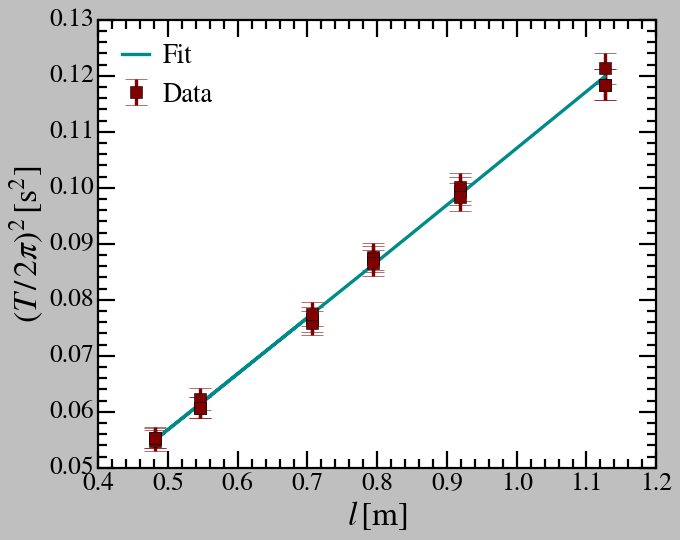

In [74]:
fig, ax = plt.subplots(figsize=(9,7))

ax.errorbar(data['l'], (data['T']/2/np.pi)**2,
            yerr=2 * (0.025/data['T']) * (data['T']/2/np.pi)**2, 
            fmt=' s', markersize=10,elinewidth=3,capsize=10,
            color='maroon',label='Data')

ax.plot(data['l'], pendulum_fitter._get_model(data['l'],fitting_result['params']),
        color='darkcyan',label='Fit')

ax.set_xlabel(r'$l\,[$m$]$')
ax.set_ylabel(r'$\left(T \, / \, 2\pi\right)^2 \, [$s$^2]$')

ax.legend(loc='upper left', ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5, fontsize=24)